# Deep Learning

## Part 2: Open Task - Part Of Speech Tagging (with pretrained model)

---

> Kostis Konstantinos (p3352311) <br>
> Karousis Nikolaos (p3352321) <br>
> MSc Data Science (Part-Time) <br>
> Athens University Of Economics and Business

## Open Task

For the part 2 of the assignment the open task was selected, which is about part-of-speech tagging.

This notebook implements the POS Tagging by using a pretrained Bert model.

## Dataset description
The dataset used, refers to the english language of the Universal Dependencies tree banks and more specifically GUM from Georgetown University. It contains 10761 sentences from different genres: academic, blog, fiction, government, news, nonfiction, social, spoken, web, wiki. The dataset is downloaded from Github and parsed using the conllu package, via a custom class named DatasetHandler.

- Treebank index page can be found here https://universaldependencies.org/treebanks/en_gum/index.html
- The actual data (train, dev, test) files can be found at https://github.com/UniversalDependencies/UD_English-GUM/tree/master

In [1]:
# Install needed libraries
!pip install -U conllu gensim requests tensorflow==2.12.0 keras-tuner==1.4.7 pandas==1.5.3 numpy==1.23.5 scikit-learn==1.3.0 matplotlib==3.8.4 transformers==4.48.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 109.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 88.3 MB/s eta 0:00:00

In [2]:
## Allow access to the code directory
import sys
import os
from google.colab import drive

# Mount the drive
drive.mount('/content/drive', force_remount=True)

# Define the base path
base_path = '/content/drive/MyDrive/deep-learning-msc-data-science-2024-2025'

# Define the code path
code_folder = os.path.join(base_path, 'code')

# Add the 'code' folder to the sys.path
sys.path.append(code_folder)

Mounted at /content/drive


In [3]:
# Load libraries
import tensorflow as tf

from constants import *
from pos_utils import *
from pos_pretrained import *


## Fetch/Load the data

In [4]:
data_directory = os.path.join(base_path, 'data', 'pos_en_gmu')

train_ds_handler = DatasetHandler(data_directory, POS_TAG_TRAIN_URL, 'train')
train_ds_handler.fetch()

dev_ds_handler = DatasetHandler(data_directory, POS_TAG_DEV_URL, 'dev')
dev_ds_handler.fetch()

test_ds_handler = DatasetHandler(data_directory, POS_TAG_TEST_URL, 'test')
test_ds_handler.fetch()

In [5]:
train_data = train_ds_handler.sentences
val_data = dev_ds_handler.sentences
test_data = test_ds_handler.sentences

## Extract the labels

In [6]:
label_extractor = LabelExtractor()
label_extractor.extract(train_data)

LabelExtractor()

## Preprocess the data (tokenization, padding and alignment)

In [7]:
tokenizer = fetch_tokenizer()
data_processor = Processor(tokenizer, label_extractor)

train_input_ids, train_attention_masks, train_labels = data_processor.preprocess_data(train_data)
val_input_ids, val_attention_masks, val_labels = data_processor.preprocess_data(val_data)
test_input_ids, test_attention_masks, test_labels = data_processor.preprocess_data(test_data)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Instantiate a model (Bert with MLP head)

In [8]:
model = BertWithMLPHead(num_labels = label_extractor.num_labels)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

## Convert train / val / test splits to Tensorflow Datasets

In [9]:
BATCH_SIZE = 16

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': train_input_ids,
    'attention_mask': train_attention_masks
}, train_labels)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': val_input_ids,
    'attention_mask': val_attention_masks
}, val_labels)).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': test_input_ids,
    'attention_mask': test_attention_masks
}, test_labels)).batch(BATCH_SIZE)

## Initialize the Trainer

In [11]:
model_directory = os.path.join(base_path, MODELS_DIR)
trainer = Trainer(model_directory, POS_TAG_PRETRAINED_WEIGHTS, model, label_extractor, epochs=5)
trainer.compile_model()

## Fit the model

In [12]:
trainer.fit_model(train_dataset, val_dataset)

Epoch 1/5


1/1 [==============================] - 1s 603ms/step

Epoch 1 - Precision: 0.9623, Recall: 0.9609, F1 Score: 0.9586

Epoch 1: val_f1 improved from -inf to 0.95856, saving model to /content/drive/MyDrive/deep-learning-msc-data-science-2024-2025/models/pos_tag_pretrained.weights.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


595/595 [==============================] - 1621s 3s/step - loss: 0.4752 - masked_accuracy: 0.8807 - val_loss: 0.1347 - val_masked_accuracy: 0.9624 - val_precision: 0.9623 - val_recall: 0.9609 - val_f1: 0.9586
Epoch 2/5
1/1 [==============================] - 1s 611ms/step

Epoch 2 - Precision: 0.9703, Recall: 0.9647, F1 Score: 0.9648

Epoch 2: val_f1 improved from 0.95856 to 0.96484, saving model to /content/drive/MyDrive/deep-learning-msc-data-science-2024-2025/models/pos_tag_pretrained.weights.h5


/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


595/595 [==============================] - 1592s 3s/step - loss: 0.1276 - masked_accuracy: 0.9714 - val_loss: 0.1214 - val_masked_accuracy: 0.9674 - val_precision: 0.9703 - val_recall: 0.9647 - val_f1: 0.9648
Epoch 3/5
1/1 [==============================] - 1s 769ms/step

Epoch 3 - Precision: 0.9705, Recall: 0.9686, F1 Score: 0.9675

Epoch 3: val_f1 improved from 0.96484 to 0.96749, saving model to /content/drive/MyDrive/deep-learning-msc-data-science-2024-2025/models/pos_tag_pretrained.weights.h5


/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


595/595 [==============================] - 1591s 3s/step - loss: 0.0710 - masked_accuracy: 0.9835 - val_loss: 0.1293 - val_masked_accuracy: 0.9708 - val_precision: 0.9705 - val_recall: 0.9686 - val_f1: 0.9675
Epoch 4/5
1/1 [==============================] - 1s 749ms/step

Epoch 4 - Precision: 0.9772, Recall: 0.9771, F1 Score: 0.9768

Epoch 4: val_f1 improved from 0.96749 to 0.97682, saving model to /content/drive/MyDrive/deep-learning-msc-data-science-2024-2025/models/pos_tag_pretrained.weights.h5


/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


595/595 [==============================] - 1594s 3s/step - loss: 0.0468 - masked_accuracy: 0.9893 - val_loss: 0.1208 - val_masked_accuracy: 0.9783 - val_precision: 0.9772 - val_recall: 0.9771 - val_f1: 0.9768
Epoch 5/5
1/1 [==============================] - 1s 611ms/step

Epoch 5 - Precision: 0.9755, Recall: 0.9753, F1 Score: 0.9750

Epoch 5: val_f1 did not improve from 0.97682
595/595 [==============================] - 1579s 3s/step - loss: 0.0358 - masked_accuracy: 0.9918 - val_loss: 0.1597 - val_masked_accuracy: 0.9766 - val_precision: 0.9755 - val_recall: 0.9753 - val_f1: 0.9750


## Plot training accuracy and loss curves

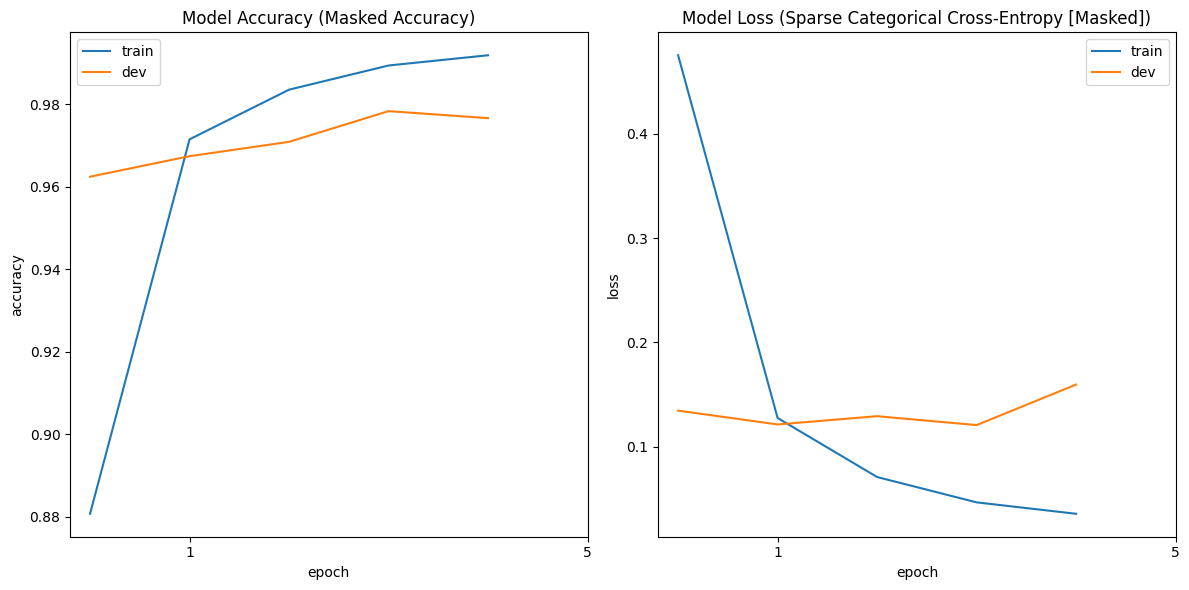

In [13]:
trainer.plot_curves()

## Evaluate the fine-tuned model on the training set (classification report)

In [14]:
train_classification_report_df, train_macro_average_df = trainer.classification_report(train_dataset)

1/1 [==============================] - 1s 886ms/step


In [15]:
train_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,0,ADJ,0.988707,0.995569,0.992126,0.999260
1,1,ADP,0.993808,0.995349,0.994578,0.999784
2,2,ADV,0.985029,0.989400,0.987209,0.998918
3,3,AUX,0.999319,0.999027,0.999173,0.999814
4,4,CCONJ,0.999629,0.999444,0.999536,0.999769
5,5,DET,0.999550,0.999400,0.999475,0.999922
6,6,INTJ,0.993092,0.928918,0.959933,0.995154
7,7,NOUN,0.982605,0.997238,0.989868,0.999305
8,8,NUM,0.986256,0.997426,0.991810,0.999901
9,9,PART,0.999098,0.999639,0.999369,0.999954


In [16]:
train_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.981773,0.981679,0.981618,0.993743


## Evaluate the fine-tuned model on the validation set (classification report)

In [17]:
dev_classification_report_df, dev_macro_average_df = trainer.classification_report(val_dataset)

1/1 [==============================] - 1s 623ms/step


In [18]:
dev_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,0,ADJ,0.934795,0.969318,0.951743,0.982350
1,1,ADP,0.986030,0.982488,0.984256,0.997865
2,2,ADV,0.961670,0.955970,0.958811,0.986263
3,3,AUX,0.994347,0.993723,0.994035,0.998938
4,4,CCONJ,0.995187,0.998792,0.996986,0.999930
5,5,DET,0.998417,0.997890,0.998154,0.999555
6,6,INTJ,0.930147,0.890845,0.910072,0.957400
7,7,NOUN,0.942703,0.981098,0.961517,0.987119
8,8,NUM,0.979118,0.981395,0.980256,0.992570
9,9,PART,0.997831,0.997831,0.997831,0.999652


In [19]:
dev_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.938147,0.934264,0.935783,0.955102


## Evaluate the fine-tuned model on the test set (classification report)

In [20]:
test_classification_report_df, test_macro_average_df = trainer.classification_report(test_dataset)

1/1 [==============================] - 0s 314ms/step


In [21]:
test_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,0,ADJ,0.921166,0.957351,0.938910,0.974609
1,1,ADP,0.983153,0.988705,0.985921,0.997117
2,2,ADV,0.967228,0.947917,0.957475,0.984745
3,3,AUX,0.991797,0.995509,0.993650,0.998546
4,4,CCONJ,0.995238,0.998805,0.997018,0.999596
5,5,DET,0.997629,0.998576,0.998102,0.999896
6,6,INTJ,0.957055,0.847826,0.899135,0.952216
7,7,NOUN,0.918667,0.979277,0.948004,0.985755
8,8,NUM,0.945180,0.998004,0.970874,0.993170
9,9,PART,0.998609,0.995839,0.997222,0.998014


In [22]:
test_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.93558,0.941274,0.935305,0.954831


## The Model Architecture

In [23]:
trainer.model.summary()

Model: "bert_with_mlp_head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model (TFBertModel)  multiple                 109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 dense (Dense)               multiple                  393728    
                                                                 
 dropout_38 (Dropout)        multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  131328    
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
 dense_2 (Dense)             multiple           

## Remarks

- The model overfits a bit, since the loss decreases and then increases after epoch 3. But the increase is not dramatic.
- On the test set the model achieves a 95.48% on Precision-Recall AUC
- The class `X` cannot be distinguished and this is reflected on the Precision-Recall AUC score as the model achieves 57.49%